# Lab 3 Discriminative and generative models

### 0. Imports

In [17]:
import os
from  collections import Counter
import numpy as np
import matplotlib.pyplot as plt


## 1. Divide the data in two groups: training and test examples.

In [18]:
# Directories for training and testing data
train_dir = './data/train-mails'
test_dir = './data/test-mails'

## 2. Parse both the training and test examples to generate both the spam and ham data sets.

In [19]:
def parse_emails(directory):
    """Parse emails from a directory and categorize as spam or ham based on filename prefix
    
    Args:
        directory (str): Directory containing email files
        
    Returns:
        tuple: (ham_emails, spam_emails) lists of file paths
    """
    ham_emails = []
    spam_emails = []
    
    # Get all files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        # Check if it's spam or ham based on filename prefix
        # In the ling-spam dataset, filenames starting with 'spmsg' are spam
        if filename.startswith('spmsg'):
            spam_emails.append(filepath)
        else:
            ham_emails.append(filepath)
    
    return ham_emails, spam_emails


In [20]:
# Parse training emails
train_ham_emails, train_spam_emails = parse_emails(train_dir)
print(f"Training data: {len(train_ham_emails)} ham emails, {len(train_spam_emails)} spam emails")

# Parse test emails
test_ham_emails, test_spam_emails = parse_emails(test_dir)
print(f"Test data: {len(test_ham_emails)} ham emails, {len(test_spam_emails)} spam emails")


Training data: 351 ham emails, 351 spam emails
Test data: 130 ham emails, 130 spam emails


## 3. Generate a dictionary from the training data.

In [21]:
# Function to create a dictionary from email text data
def make_Dictionary(train_dir):
    emails = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
    all_words = []
    for mail in emails:
        with open(mail, encoding='latin1') as m:
            for i, line in enumerate(m):
                if i == 2:  # Usually, the 3rd line contains useful content
                    words = line.split()
                    all_words += words

    dictionary = Counter(all_words)

    # Removing non-alphabetic words and single-character words
    for item in list(dictionary):
        if not item.isalpha() or len(item) == 1:
            del dictionary[item]

    
    return dictionary

In [22]:
train_dictionary = make_Dictionary(train_dir)

In [23]:
# print the number of keys in the dictionary
print(len(train_dictionary))

16883


## 4. Extract features from both the training data and test data.

In [24]:
def extract_features(mail_dir, dictionary):
    files = [os.path.join(mail_dir, fi) for fi in os.listdir(mail_dir)]
    # Use the actual size of the dictionary instead of a fixed 3000
    dict_size = len(dictionary)
    features_matrix = np.zeros((len(files), dict_size))

    # Convert dictionary to list for indexing
    dictionary_list = list(dictionary.keys())

    for docID, fil in enumerate(files):
        with open(fil, encoding='utf-8') as fi:
            for i, line in enumerate(fi):
                if i == 2:  # Usually the subject/content line
                    words = line.split()
                    for word in words:
                        # Check if word is in dictionary
                        if word in dictionary:
                            wordID = dictionary_list.index(word)
                            features_matrix[docID, wordID] = words.count(word)

    return features_matrix

In [25]:
train_features = extract_features(train_dir, train_dictionary)
print(train_features)

[[1. 1. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [26]:
test_features = extract_features(test_dir, train_dictionary)
print(test_features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 5. Implement the Naïve Bayes from scratch, and fit it to the training data.

In [27]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.classes = ['ham', 'spam']
        self.class_prior = {}
        self.class_conditional_prob = {}
        self.vocab_size = 0
        self.alpha = alpha
    
    def fit(self, train_features, y):
        """
        Fit the Naive Bayes classifier to the training data
        
        Args:
            train_features: Feature matrix (document-term matrix)
            y: Labels ('ham' or 'spam')
        """
        n_samples, n_features = train_features.shape
        self.vocab_size = n_features
        
        # Calculate class priors
        class_counts = {}
        for class_label in self.classes:
            class_counts[class_label] = sum(1 for label in y if label == class_label)
            self.class_prior[class_label] = class_counts[class_label] / n_samples
            
        # Initialize class conditional probabilities
        self.class_conditional_prob = {}
        for class_label in self.classes:
            self.class_conditional_prob[class_label] = np.zeros(n_features)
            
        # Calculate class conditional probabilities with Laplace smoothing
        for class_label in self.classes:
            # Get indices of samples belonging to class c
            class_indices = [i for i in range(n_samples) if y[i] == class_label]
            
            # Sum word occurrences for class_label
            train_features_per_class = train_features[class_indices]
            word_counts_per_class = np.sum(train_features_per_class, axis=0)

            
            # Calculate conditional probabilities with Laplace smoothing
            total_words_per_class = np.sum(word_counts_per_class)
            self.class_conditional_prob[class_label] = (word_counts_per_class + self.alpha) / (total_words_per_class + self.alpha * self.vocab_size)
    def predict(self, train_features):
        """
        Predict class labels for samples in X
        
        Args:
            train_features: Feature matrix (document-term matrix)
            
        Returns:
            list: Predicted labels ('ham' or 'spam')
        """
        predictions = []
        
        for features in train_features:
            # Calculate posterior probability for each class 
            posteriors = {}
            for class_label in self.classes:
                # Start with log of prior probability
                log_posterior = np.log(self.class_prior[class_label])
                
                # Add log of conditional probabilities (using log to avoid underflow)
                # Only consider non-zero features to improve efficiency
                for i in range(len(features)):
                    if features[i] > 0:
                        # If the word appears in the document, add log(P(word|class)) * count
                        log_posterior += features[i] * np.log(self.class_conditional_prob[class_label][i])
                
                posteriors[class_label] = log_posterior
            
            # Choose class with highest posterior probability
            predictions.append(max(posteriors, key=posteriors.get))
        
        return predictions
    
    def plot_confusion_matrix(self, y_true, y_pred):
        
        # Calculate confusion matrix manually
        cm = np.zeros((2,2))
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i] == 'ham':
                cm[0,0] += 1 
            elif y_true[i] == y_pred[i] == 'spam':
                cm[1,1] += 1
            elif y_true[i] == 'ham' and y_pred[i] == 'spam':
                cm[0,1] += 1
            else:
                cm[1,0] += 1
                
        plt.figure(figsize=(10, 7))
        
        # Create a matplotlib heatmap instead of using seaborn
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        # Add labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes)
        plt.yticks(tick_marks, self.classes)
        
        # Add text annotations
        thresh = cm.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'g'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
        
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.tight_layout()
        plt.show()
        
        # Calculate metrics
        accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
        precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
    def predict_proba(self, train_features):
        """
        Predict probability estimates for samples in X
        
        Args:
            X: Feature matrix (document-term matrix)
            
        Returns:
            array: Probability estimates for spam class
        """
        proba = []
        
        for features in train_features:
            # Calculate posterior probability for each class (in log space)
            posteriors = {}
            for class_label in self.classes:
                # Start with log of prior probability
                log_posterior = np.log(self.class_prior[class_label])
                
                # Add log of conditional probabilities
                for i in range(len(features)):
                    if features[i] > 0:
                        log_posterior += features[i] * np.log(self.class_conditional_prob[class_label][i])
                
                posteriors[class_label] = log_posterior
            
            # Convert log probabilities to actual probabilities
            # First, get the maximum log probability to avoid numerical issues
            max_log_prob = max(posteriors.values())
            exp_posteriors = {c: np.exp(p - max_log_prob) for c, p in posteriors.items()}
            
            # Normalize to get probabilities that sum to 1
            total = sum(exp_posteriors.values())
            normalized_posteriors = {c: p / total for c, p in exp_posteriors.items()}
            
            # Return probability for spam class
            proba.append(normalized_posteriors['spam'])
        
        return np.array(proba)
    
    def plot_roc_curve(self, train_features, y_true):
        """
        Plot ROC curve with TPR on vertical axis and FPR on horizontal axis
        
        Args:
            X: Feature matrix (document-term matrix)
            y_true: True labels ('ham' or 'spam')
        """
        # Get probability estimates for spam class
        y_scores = self.predict_proba(train_features)
        
        # Convert labels to binary (1 for spam, 0 for ham)
        y_binary = np.array([1 if label == 'spam' else 0 for label in y_true])
        
        # Calculate ROC curve
        thresholds = np.sort(np.unique(y_scores))
        thresholds = np.append(thresholds, 1.0 + 1e-10)  # Add an extra threshold at the end
        
        tpr_values = []
        fpr_values = []
        
        for threshold in thresholds:
            # Predict based on threshold
            y_pred = (y_scores >= threshold).astype(int)
            
            # Calculate TP, FP, TN, FN
            tp = np.sum((y_binary == 1) & (y_pred == 1))
            fp = np.sum((y_binary == 0) & (y_pred == 1))
            tn = np.sum((y_binary == 0) & (y_pred == 0))
            fn = np.sum((y_binary == 1) & (y_pred == 0))
            
            # Calculate TPR and FPR
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            tpr_values.append(tpr)
            fpr_values.append(fpr)
        
        # Plot ROC curve
        plt.figure(figsize=(10, 7))
        plt.plot(fpr_values, tpr_values, lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random classifier')
        
        # Calculate area under the curve (AUC)
        auc = 0
        for i in range(len(fpr_values) - 1):
            auc += abs((fpr_values[i+1] - fpr_values[i]) * (tpr_values[i+1] + tpr_values[i]) / 2)
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve - AUC: {auc:.4f}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        return auc

In [28]:
# Prepare labels for training data
train_labels = []
for filename in os.listdir(train_dir):
    if filename.startswith('spmsg'):
        train_labels.append('spam')
    else:
        train_labels.append('ham')

# Prepare labels for test data
test_labels = []
for filename in os.listdir(test_dir):
    if filename.startswith('spmsg'):
        test_labels.append('spam')
    else:
        test_labels.append('ham')


In [46]:
naive_bayes = NaiveBayes(alpha=1.0)
naive_bayes.fit(train_features, train_labels)

## 6. Make predictions for the test data.

In [47]:
test_predictions = naive_bayes.predict(test_features)

## 7. Measure the spam-filtering performance for each approach through the confusion matrix,
accuracy, precision, recall, and F1 score.

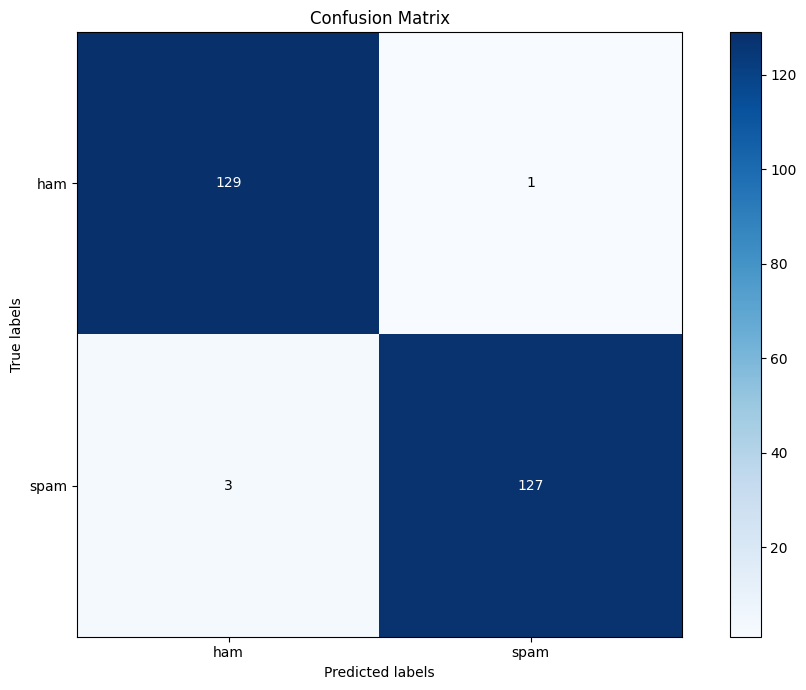

Accuracy: 0.9846
Precision: 0.9922
Recall: 0.9769
F1 Score: 0.9845


In [48]:
naive_bayes.plot_confusion_matrix(test_labels, test_predictions)

## 8. Plot a graph with true positive rate on the vertical axis and with false positive rate on the horizontal axis

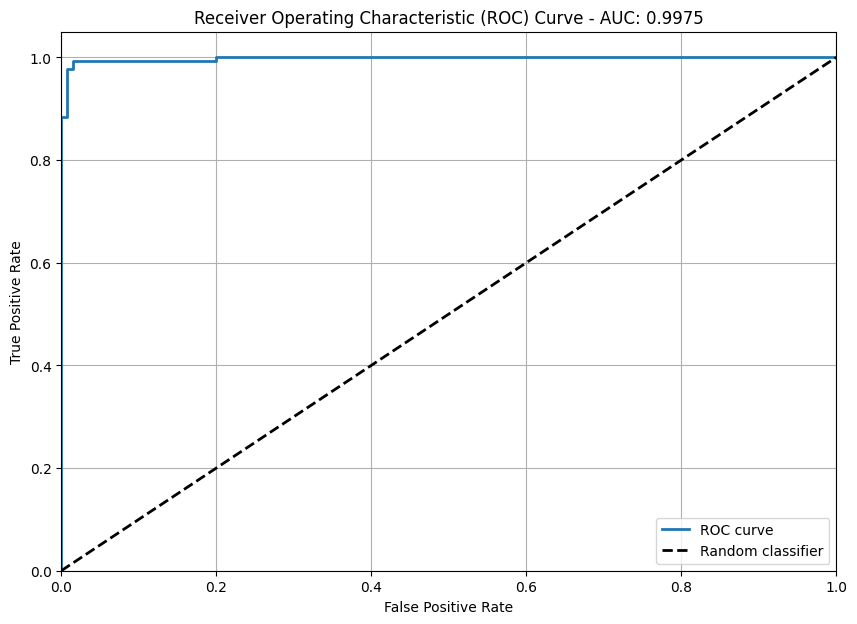

Area Under ROC Curve (AUC): 0.9975


In [32]:
auc = naive_bayes.plot_roc_curve(test_features, test_labels)
print(f"Area Under ROC Curve (AUC): {auc:.4f}")

## 9. Discuss the results